## crop the images

In [2]:
import os
from osgeo import gdal, ogr
from shapely.geometry import box , Point
import geopandas as gpd
import rasterio
from rasterio.mask import mask

from tqdm.auto import tqdm

/Users/banoczymartin/OE Projects/Mapping Upper Canopy Level/venvs_can/canopysegmentation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### split tif

In [187]:
def split_tif(tif_path, out_folder, tile_size=(250, 250)):
    ds = gdal.Open(tif_path)
    if ds is None:
        print(f"Could not open input TIF file: {tif_path}")
        return
    
    #get raster width and height
    width = ds.RasterXSize
    height = ds.RasterYSize

    #calc. the number of rows and columns
    num_cols = (width + tile_size[0] - 1) // tile_size[0]
    num_rows = (height + tile_size[1] - 1) // tile_size[1]
    
    total_tiles = num_rows * num_cols
    with tqdm(total=total_tiles, desc='splitting tifs') as pbar:
        for i in range(num_rows):
            for j in range(num_cols):
                #bbox coordinates
                xmin = j * tile_size[0]
                ymin = i * tile_size[1]
                xmax = min((j + 1) * tile_size[0], width)
                ymax = min((i + 1) * tile_size[1], height)
                
                #crop & save
                output_tif = os.path.join(out_folder, f'tile_tif_{i}_{j}.tif')
                gdal.Translate(output_tif, ds, srcWin=[xmin, ymin, xmax - xmin, ymax - ymin])
                pbar.update(1)
    
#out_folder = '../data/tiles'
#tile_size = (250, 250)  #tile size in pixels
#split_tif(tif_path, out_folder, tile_size)


### splitting shapefile with splitted tif file's locations

In [188]:
def split_shp(bigger_shapefile_path, tif_file_path, output_folder):
    #read the shp
    gdf_bigger = gpd.read_file(bigger_shapefile_path)
    
    #read the tif and get the bbox
    with rasterio.open(tif_file_path) as src:
        bbox = box(*src.bounds)
    
    #clip the bigger shapefile to the extent of the TIF file
    gdf_intersection = gdf_bigger[gdf_bigger.intersects(bbox)]
    
    splitted_name = os.path.basename(tif_file_path).split('_')
    out_path = os.path.join(output_folder,
                            f'tile_shp_{splitted_name[2]}_{os.path.splitext(splitted_name[3])[0]}.shp')
    gdf_intersection.to_file(out_path)

#tif_path = '../data/actual_data/2023-02-23-bakonyszucs_im_cropped.tif'
#shp_path = '../data/actual_data/Pont.shp'
#out_folder ='../data/distributed'
#split_shp(shp_path, 'output_tiles/tile_tif_0_0.tif', '../data/tiles')


## concat tif & shp split

In [14]:
def split(tif_path, shp_path, output_folder, tile_size=(250, 250)):
    
    split_tif(tif_path,output_folder,tile_size)

    extension = '.tif'
    files = os.listdir(output_folder)
    total_files = len(files)
    tif_files=[]
    with tqdm(total=total_files, desc='splitting shps') as pbar:
        for file in files:
            if file.endswith(extension):
                tif_files.append(os.path.join(output_folder, file))
            pbar.update(1)
            
    total_files = len(tif_files)
    with tqdm(total=total_files, desc='splitting shps') as pbar:
        for tif_path in tif_files:
            split_shp(shp_path, tif_path, output_folder)
            pbar.update(1)
    print('success')    

In [189]:
def split(tif_path, shp_path, output_folder, tile_size=(250, 250)):
    
    split_tif(tif_path,output_folder,tile_size)

    extension = '.tif'
    files = os.listdir(output_folder)
    total_files = len(files)
    with tqdm(total=total_files, desc='splitting shps') as pbar:
        for file in files:
            if file.endswith(extension):
                split_shp(shp_path, os.path.join(output_folder, file), output_folder)
            pbar.update(1)

In [6]:
def get_tif_size(tif_file_path):
    with rasterio.open(tif_file_path) as src:
        width = src.width
        height = src.height
    return width, height
#print(get_tif_size('../data/tiles/tile_tif_1_1.tif'))

## convert SHP to PNG

In [ ]:
#matplotlib version

import os
import geopandas as gpd
import matplotlib.pyplot as plt

def convert_SHPtoPNG(shp_path,png_path, point_size=1, dpi = 300, bg_color='black',fg_color='white', fig_size=(50,50)):
    '''
    returns the point as well as a list of tuples
    '''
    
    gdf = gpd.read_file(shp_path)

    xmin, ymin, xmax, ymax = gdf.total_bounds
    print(gdf.total_bounds)
    #plot points as white boxes on a black background
    fig, ax = plt.subplots(figsize=fig_size)
    #ax.set_xlim(xmin, xmax)
    #ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 250)
    
    ax.set_facecolor(bg_color)
    ax.scatter(gdf.geometry.x, gdf.geometry.y, s=point_size, color=fg_color) #point size

    #save the plot as a PNG image
    plt.savefig(png_path, bbox_inches='tight', pad_inches=0, facecolor='black', dpi=dpi)
    plt.close()
    
    #points = [(p.x, p.y) for p in gdf.geometry]
    return list(zip(gdf.geometry.x,gdf.geometry.y))#points (X, Y)
    
shp_path = '../data/tiles/tile_shp_0_0.shp'
out_path = '../data/tile_png_0_0_250.png'
points = convert_SHPtoPNG(shp_path,out_path,point_size=5, fig_size=(10,10))
print(points)

In [190]:
#pillow version (working) 

from PIL import Image, ImageDraw
import rasterio
from rasterio.warp import transform_bounds
from pyproj import Transformer

def convert_SHPtoPNG(tif_path, shp_path, png_path, tile_size=(250,250), point_size=1, bg_color='black', fg_color='white'):
    '''
    Returns the point list as well as saves a PNG image with points plotted.
    '''
    gdf = gpd.read_file(shp_path)
    
    target_epsg = 23700
    with rasterio.open(tif_path) as src:
        src_crs = src.crs
        # Transform the bounding box coordinates to the target EPSG code
        transformer = Transformer.from_crs(src_crs, f'EPSG:{target_epsg}', always_xy=True)
        bbox_transformed = transform_bounds(src_crs, f'EPSG:{target_epsg}', *src.bounds)

    #xmin, ymin, xmax, ymax = gdf.total_bounds
    #print(gdf.total_bounds)
    xmin, ymin, xmax, ymax = bbox_transformed

    img_width, img_height = tile_size
    
    #new blank image
    img = Image.new('RGB', (img_width, img_height), color=bg_color)
    draw = ImageDraw.Draw(img)

#    for geom in gdf.geometry:
#        x = int((geom.x - xmin) / (xmax - xmin) * img_width)
#        y = img_height - int((geom.y - ymin) / (ymax - ymin) * img_height)
#        draw.ellipse([x - point_size, y - point_size, x + point_size, y + point_size], fill=fg_color,outline=fg_color)

#    for geom in gdf.geometry:
#        x = int((geom.x - xmin) / (xmax - xmin) * img_width)
#        y = int((geom.y - ymin) / (ymax - ymin) * img_height)
#        draw.ellipse([x - point_size, y - point_size, x + point_size, y + point_size], fill=fg_color, outline=fg_color)

    for geom in gdf.geometry:
        x = int((geom.x - xmin) / (xmax - xmin) * img_width)
        y = int((ymax - geom.y) / (ymax - ymin) * img_height)  # Invert
        draw.ellipse([x - point_size, y - point_size, x + point_size, y + point_size], fill=fg_color, outline=fg_color)

    img.save(png_path)
    img.close()

    #extract points
    points = list(zip(gdf.geometry.x, gdf.geometry.y))  # List of tuples (X, Y)
    return points

In [ ]:
#get points with ogr

from osgeo import ogr

shp_path = "../data/tile_shp_0_0_copy.shp"
input_ds = ogr.Open(shp_path)

if input_ds is None:
    print(f"Could not open input shapefile: {shp_path}")
    exit()

# Get the input layer
input_layer = input_ds.GetLayer()

# List to store points
points_list = []

# Loop through features to extract points
for feature in input_layer:
    geom = feature.GetGeometryRef()
    if geom is not None:
        for i in range(geom.GetPointCount()):
            point = geom.GetPoint(i)
            points_list.append(point)

# Close the shapefile
input_ds = None

# Print the list of points
print(points_list)


In [ ]:
gdf = gpd.read_file(shp_path)
min_x, min_y, max_x, max_y = gdf.total_bounds

# Calculate the difference between maximum and minimum coordinate values
x_resolution = max_x - min_x
y_resolution = max_y - min_y
print(x_resolution, y_resolution)

### copy shp param.

In [ ]:
output_shp = '../data/tile_shp_0_0_copy.shp' #'../data/actual_data/output_points.shp'
input_shp = '../data/tiles/tile_shp_0_0.shp'
input_ds = ogr.Open(shp_path)

if input_ds is None:
    print(f"Could not open input shapefile: {shp_path}")
    exit()
    
# Get the input layer
input_layer = input_ds.GetLayer()

# Create a new shapefile for writing
driver = ogr.GetDriverByName('ESRI Shapefile')
if os.path.exists(output_shp):
    driver.DeleteDataSource(output_shp)
output_ds = driver.CreateDataSource(output_shp)
output_layer = output_ds.CreateLayer(input_layer.GetName(), input_layer.GetSpatialRef(), input_layer.GetGeomType())

# Define the fields and add them to the output layer
field_def_list = []
for i in range(input_layer.GetLayerDefn().GetFieldCount()):
    field_def = input_layer.GetLayerDefn().GetFieldDefn(i)
    field_def_list.append(field_def)
    output_layer.CreateField(field_def)
print(field_def_list, len(field_def_list))
# Copy features from input layer to output layer with modified geometry (e.g., move features)
for feature in input_layer:
    geom = feature.GetGeometryRef()
    # Modify the geometry here (e.g., move the feature)
    # Example: geom.SetPoint(0, NEW_X, NEW_Y)  # Move the first point of the geometry
    new_feature = ogr.Feature(output_layer.GetLayerDefn())
    new_feature.SetGeometry(geom)
    if geom is not None:
        print(geom.GetPoint())
    for i, field_def in enumerate(field_def_list):
        new_feature.SetField(i, feature.GetField(i))
    output_layer.CreateFeature(new_feature)
    new_feature = None

# Close the shapefiles
input_ds = None
output_ds = None

## get the white dots center point on a png image

In [ ]:
#very slow compared to opencv
from PIL import Image
import numpy as np
from scipy import ndimage
def getPoints_fromPNG(image_path):
    img = Image.open(image_path)
    
    #grayscale
    img_gray = img.convert('L')
    
    threshold = 254
    img_binary = np.array(img_gray) > threshold
    
    #find connected components in the binary mask
    labeled_img, num_features = ndimage.label(img_binary)
    
    white_dot_centers = []
    
    for label in range(1, num_features + 1):
        #find coordinates of all pixels belonging to the connected component
        rows, cols = np.where(labeled_img == label)
        
        #calc. centroid as the mean of x and y coordinates
        center_x = np.mean(cols)
        center_y = np.mean(rows)
        
        #append centroid
        white_dot_centers.append((center_x, center_y))
    
    return white_dot_centers

white_dot_centers = getPoints_fromPNG(image_path)
print(white_dot_centers)
white_dot_centers.count((1071.0,3.0))
len(white_dot_centers)

In [191]:
#fastest way
import cv2
def getPoints_fromPNG(image_path):
    img = cv2.imread(image_path)
    
    #grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #threshold
    _, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    
    #find contours
    contours, _ = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    white_dot_centers = []
    for contour in contours:
        #calculate the moments
        M = cv2.moments(contour)
        
        #calculate centroid coordinates
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            white_dot_centers.append((cX, cY))
    
    return white_dot_centers

## create shp from points

In [ ]:
import os
from osgeo import ogr, osr

In [192]:
def create_shapefile(output_shp, points):
    driver = ogr.GetDriverByName('ESRI Shapefile')
    if os.path.exists(output_shp):
        driver.DeleteDataSource(output_shp)
    output_ds = driver.CreateDataSource(output_shp)
    
    spatial_ref = osr.SpatialReference()
    #spatial_ref.ImportFromEPSG(4326)  # WGS84
    spatial_ref.ImportFromEPSG(23700) # new
    
    #new layer
    output_layer = output_ds.CreateLayer("points", spatial_ref, ogr.wkbPoint)
    
    #define a field for the point ID
    id_field = ogr.FieldDefn("ID", ogr.OFTInteger)
    output_layer.CreateField(id_field)
    
    #create points and add them to the layer
    for i, (x, y) in enumerate(points):
        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(x,y)
        
        feature = ogr.Feature(output_layer.GetLayerDefn())
        feature.SetGeometry(point)
        feature.SetField("ID", i+1)
        output_layer.CreateFeature(feature)
        
        feature = None
    
    output_ds = None


#output_shp = '../data/frompng_tile_shp_0_0.shp'
#points = white_dot_centers#[(10, 20), (30, 40), (50, 60)]  # Example list of coordinates

#create_shapefile(output_shp, points)


## get tif informations

In [193]:
import rasterio
from rasterio.warp import transform_bounds
from pyproj import Transformer

In [ ]:
def get_tif_location(tif_path, target_epsg):
    with rasterio.open(tif_path) as src:
        src_crs = src.crs
        # Transform the bounding box coordinates to the target EPSG code
        transformer = Transformer.from_crs(src_crs, f'EPSG:{target_epsg}', always_xy=True)
        bbox_transformed = transform_bounds(src_crs, f'EPSG:{target_epsg}', *src.bounds)
        # Convert the transformed coordinates to the desired format (here, simply printing)
        print(f"Bounding box coordinates in EPSG:{target_epsg}: {bbox_transformed}")

# Example usage:
tif_path = "../data/tiles/tile_tif_0_0.tif"
target_epsg = 23700  # Example EPSG code (WGS 84)
get_tif_location(tif_path, target_epsg)


In [72]:
# get tif info.
tif_path = '../data/tiles/original/tile_tif_0_0.tif'
with rasterio.open(tif_path) as src:
    transform = src.transform  #affine transformation object
    crs = src.crs  #coordinate Reference System
print("Affine transformation:", transform)
print("Coordinate Reference System (CRS):", crs)

Affine transformation: | 0.15, 0.00, 549221.34|
| 0.00,-0.15, 221189.34|
| 0.00, 0.00, 1.00|
Coordinate Reference System (CRS): EPSG:23700


## pipeline

In [194]:
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
# 1. data prep.
#   - splitting geo. images
split('../data/actual_data/2023-02-23-bakonyszucs_im_cropped.tif',
      '../data/actual_data/Pont.shp',
      '../data/tiles/original')

#   - convert to .png for the model
convert_SHPtoPNG('../data/tiles/original/tile_tif_0_0.tif',
                 '../data/tiles/original/tile_shp_0_0.shp',
                 '../data/tiles/formatted/shp_0_0_png.png',
                 3)
# 2. prediction

# ****
# model pred.
# ****

# 3. get the predicted points's image coordinates
image_coords = getPoints_fromPNG('../data/tiles/formatted/shp_0_0_png.png')

# 4. creating the shapefile
#   - img_coords -> geo_coords.
geo_coords = [transform * (x, y) for x, y in image_coords]

#   - geo_coords -> Points (obj.)
point_geoms = [Point(coord) for coord in geo_coords]

#   - create a GeoDataFrame with the Points
gdf = gpd.GeoDataFrame(geometry=point_geoms, crs=crs)  # Adjust CRS as needed

#   - save the GeoDataFrame as a shapefile
gdf.to_file("../results/predicted_points_0_0.shp")

## create png dataset

In [7]:
import os
from tqdm.auto import tqdm
import numpy as np

In [195]:
def extend_image_shape(image_array: np.array, size=(250,250)):
    new_image_array = np.zeros((250, 250), dtype=image_array.dtype)
    #start_row = (new_image_array.shape[0] - image_array.shape[0]) // 2
    #start_col = (new_image_array.shape[1] - image_array.shape[1]) // 2
    start_col=0
    start_row=0

    end_row = start_row + image_array.shape[0]
    end_col = start_col + image_array.shape[1]
    new_image_array[start_row:end_row, start_col:end_col] = image_array

    #cv2.imwrite("output_image_filled2.png", new_image_array)
    return new_image_array

def scale_pixel_values(input_dataset):
    band = input_dataset.GetRasterBand(1)
    data = band.ReadAsArray()
    
    if np.any(data < 0):
        print('empty parts')
        mask = (data > 200) & (data < 250)
        print(mask)
        non_neg_min_val = np.min(data[mask])
        data[data < 0] = non_neg_min_val
        
    #scale pixel values to fit within the range of uint16
    min_val = np.min(data)
    print(f'min: {min_val}')
    max_val = np.max(data)
    print(f'max: {max_val}')
    
    scale = 65535
    scaled_data = ((data - min_val) / (max_val - min_val) * scale).astype(np.uint16)

    return scaled_data

def createPNG_Dataset(folder, out_folder, tile_size=(250,250),point_size=1,bg_color='black',fg_color='white'):
    files = os.listdir(folder)
    total_count= len(files)
    with tqdm(total=total_count, desc='creating png dataset (tif,shp -> png)') as pbar:
        for file in files:
            if file.endswith('.shp'):
                # .shp
                tif_path = os.path.join(folder,str(file).replace('_shp_','_tif_').replace('.shp','.tif'))
                shp_path = os.path.join(folder,file)
                out_path = os.path.join(out_folder, os.path.splitext(file)[0]+'.png')
                convert_SHPtoPNG(tif_path, shp_path, out_path, tile_size, point_size,bg_color,fg_color)
            
                # .tif
                tif_file = gdal.Open(tif_path)
                scaled = scale_pixel_values(tif_file)
                if scaled.shape != tile_size:
                    scaled = extend_image_shape(scaled,tile_size)
                cv2.imwrite(out_path.replace('shp','tif'), scaled)
            pbar.update(1)

def convert_TIFtoPNG(folder, out_folder,tile_size=(250,250)):
    files = os.listdir(folder)
    total_count= len(files)
    with tqdm(total=total_count, desc='converting tifs to pngs') as pbar:
        for file in files:
            if file.endswith('.shp'):
                tif_path = os.path.join(folder,str(file).replace('_shp_','_tif_').replace('.shp','.tif'))
                out_path = os.path.join(out_folder, os.path.splitext(file)[0]+'.png')
            
                # .tif
                tif_file = gdal.Open(tif_path)
                scaled = scale_pixel_values(tif_file)
                if scaled.shape != tile_size:
                    scaled = extend_image_shape(scaled,tile_size)
                cv2.imwrite(out_path.replace('shp','tif'), scaled)
            pbar.update(1)
        

In [ ]:
folder = '../data/tiles/original'
out_folder = '../data/tiles/formatted'
size = (250,250)
#size = (500,500)

createPNG_Dataset(folder,out_folder,size)

In [196]:
def convert_PNGtoSHP(folder,out_folder, result_folder):
    filenames = os.listdir(out_folder)
    total_count = len(filenames)
    with tqdm(total=total_count, desc='converting pngs to shps') as pbar:
        for filename in filenames:
            if filename.split('_')[1]=='shp':
                image_coords = getPoints_fromPNG(os.path.join(out_folder,filename))
            
                tif_path = os.path.join(folder,filename.replace('_shp_','_tif_').replace('.png','.tif'))
                with rasterio.open(tif_path) as src:
                    transform = src.transform  #affine transformation object
                    crs = src.crs  #coordinate Reference System
                
                geo_coords = [transform * (x, y) for x, y in image_coords]
            
                #geo_coords -> Points (obj.)
                point_geoms = [Point(coord) for coord in geo_coords]
    
                #create a GeoDataFrame with the Points
                gdf = gpd.GeoDataFrame(geometry=point_geoms, crs=crs)  # Adjust CRS as needed
    
                #save the GeoDataFrame as a shapefile
                gdf.to_file(os.path.join(result_folder,'pred_'+filename.replace('.png','.shp')))
            pbar.update(1)
    

## Pipeline

In [9]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [197]:
# 1. data prep.
#   - splitting geo. images
folder = '../data/tiles/original'
out_folder = '../data/tiles/formatted'
size = (250,250)
#size = (500,500)

split('../data/actual_data/2023-02-23-bakonyszucs_im_cropped.tif',
      '../data/actual_data/Pont.shp',
      '../data/tiles/original',
      size)

#   - convert to .png for the model
# convert_TIFtoPNG(folder,out_folder,size)
createPNG_Dataset(folder,out_folder,size)


# 2. prediction

# ****
# model pred.
print('predicted')
# ****

# 4. Convert the predictions back
convert_PNGtoSHP(folder,out_folder,'../results')

creating png dataset (tif,shp -> png):  34%|███▍      | 31/90 [00:00<00:00, 258.03it/s]

empty parts
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]
min: 214.63221740722656
max: 232.72555541992188
min: 213.9507293701172
max: 233.05409240722656
min: 215.80662536621094
max: 241.03785705566406
min: 212.1826629638672
max: 235.73155212402344
min: 212.17420959472656
max: 232.93446350097656


creating png dataset (tif,shp -> png):  63%|██████▎   | 57/90 [00:00<00:00, 159.10it/s]

empty parts
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]
min: 215.1589813232422
max: 222.60562133789062
empty parts
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ...  True  True False]
 [ True  True  True ...  True False False]
 [ True  True  True ...  True False False]]
min: 213.78941345214844
max: 230.45803833007812
min: 211.89419555664062
max: 230.263916015625
min: 215.34739685058594
max: 231.81837463378906
min: 216.2160186767578
max: 233.47625732421875


creating png dataset (tif,shp -> png): 100%|██████████| 90/90 [00:00<00:00, 127.05it/s]


min: 210.28866577148438
max: 232.75799560546875
min: 213.1793212890625
max: 233.96168518066406
min: 213.91290283203125
max: 238.79856872558594
min: 214.2864532470703
max: 236.9883575439453
min: 214.3231658935547
max: 229.48812866210938
predicted


converting pngs to shps: 100%|██████████| 30/30 [00:00<00:00, 74.57it/s] 


In [10]:
test_tif = cv2.imread('../data/tiles/formatted/tile_tif_0_0.png')
test_shp = cv2.imread('../data/tiles/formatted/tile_shp_0_0.png')

print(test_tif.shape)
print(test_shp.shape)

(250, 250, 3)
(250, 250, 3)


## uneven tiff load fix

In [11]:
tif_path = '../data/tiles/original/tile_tif_2_4.tif'

tif_file = gdal.Open(tif_path)
get_tif_size(tif_path)

NameError: name 'get_tif_size' is not defined

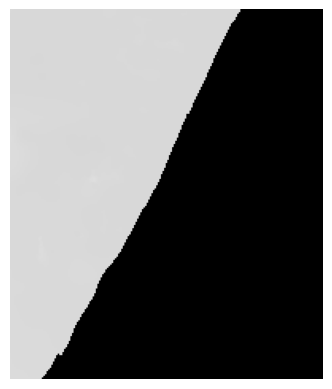

In [100]:
import matplotlib.pyplot as plt
from PIL import Image

# Open the TIF file
image = Image.open(tif_path)

# Convert the image to a NumPy array
image_array = plt.imread(tif_path)
# Plot the image
plt.imshow(image_array)
plt.axis('off')  # Turn off axis
plt.show()

In [101]:
from PIL import ImageOps
#image_array = plt.imread(tif_path)
#image_array = np.copy(image_array)
tif_file = gdal.Open(tif_path, gdal.GA_ReadOnly)

array = tif_file.ReadAsArray()
image_array = array.astype(np.float32)
#image_array[image_array == -32767.0] = 0

image_array /= np.max(image_array)

# Perform histogram equalization
image_array = cv2.equalizeHist(np.uint8(image_array * 255))

print(image_array)

#cv2.imwrite('../src/test_2_4.png', image_array)
plt.imsave('output_image.png', image_array, cmap='gray')

[[182 182 182 ...   0   0   0]
 [182 182 182 ...   0   0   0]
 [182 182 182 ...   0   0   0]
 ...
 [253 253 251 ...   0   0   0]
 [253 251 251 ...   0   0   0]
 [253 251 251 ...   0   0   0]]


In [112]:
def extend_image_shape(image_array: np.array, size=(250,250)):
    new_image_array = np.zeros((250, 250), dtype=image_array.dtype)
    #start_row = (new_image_array.shape[0] - image_array.shape[0]) // 2
    #start_col = (new_image_array.shape[1] - image_array.shape[1]) // 2
    start_col=0
    start_row=0

    end_row = start_row + image_array.shape[0]
    end_col = start_col + image_array.shape[1]
    new_image_array[start_row:end_row, start_col:end_col] = image_array

    #cv2.imwrite("output_image_filled2.png", new_image_array)
    return new_image_array

In [177]:
def scale_pixel_values(input_dataset):
    band = input_dataset.GetRasterBand(1)
    data = band.ReadAsArray()
    
    if np.any(data < 0):
        print('empty parts')
        mask = (data > 200) & (data < 250)
        print(mask)
        non_neg_min_val = np.min(data[mask])
        data[data < 0] = non_neg_min_val
        
    #scale pixel values to fit within the range of uint16
    min_val = np.min(data)
    print(f'min: {min_val}')
    max_val = np.max(data)
    print(f'max: {max_val}')
    
    scale = 65535
    scaled_data = ((data - min_val) / (max_val - min_val) * scale).astype(np.uint16)

    return scaled_data

In [182]:
tif_path='../data/tiles/original/tile_tif_1_4.tif'
size=(250,250)
tif_file = gdal.Open(tif_path, gdal.GA_ReadOnly)

image_array = scale_pixel_values(tif_file)
image_array = extend_image_shape(image_array,size)

print(image_array.shape)
print(image_array)
cv2.imwrite("output_image_filled_1_4.png", image_array)


empty parts
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]
min: 214.63221740722656
max: 232.72555541992188
(250, 250)
[[4841 4732 4598 ...    0    0    0]
 [4825 4719 4588 ...    0    0    0]
 [4866 4688 4518 ...    0    0    0]
 ...
 [9577 9375 9372 ...    0    0    0]
 [9605 9295 9087 ...    0    0    0]
 [9555 9198 8916 ...    0    0    0]]


True